# Evaluation

In [15]:
# === Importing Necessary Libraries ===
import matplotlib.pyplot as plt
import pandas as pd

# File Paths for Log Files
train_log_path = 'train_exp/run_epoch30_lr0.0002_bs16_20250708-135228/train_log.txt'
val_log_path = 'train_exp/run_epoch30_lr0.0002_bs16_20250708-135228/val_log.txt'

# === Reading and Parsing the Logs ===
def parse_log(file_path):
    epochs = []
    train_loss = []
    decoder_loss = []
    retriever_loss = []
    alpha = []
    beta = []
    gamma = []
    
    with open(file_path, 'r') as f:
        for line in f:
            epoch_data = line.split('|')
            epoch = int(epoch_data[0].split()[1])

            epochs.append(epoch)
            train_loss.append(float(epoch_data[1].split(':')[1].strip()))
            decoder_loss.append(float(epoch_data[2].split(':')[1].strip()))
            retriever_loss.append(float(epoch_data[3].split(':')[1].strip()))
            alpha.append(float(epoch_data[4].split(':')[1].strip()))
            beta.append(float(epoch_data[5].split(':')[1].strip()))
            gamma.append(float(epoch_data[6].split(':')[1].strip()))
    
    return epochs, train_loss, decoder_loss, retriever_loss, alpha, beta, gamma

# Parsing the training log file
train_epochs, train_loss, decoder_train_loss, retriever_train_loss, alpha_values, beta_values, gamma_values = parse_log(train_log_path)


In [19]:
# === Reading and Parsing Validation Log ===
def parse_val_log(file_path):
    val_epochs = []
    val_loss = []
    decoder_val_loss = []
    retriever_val_loss = []
    
    with open(file_path, 'r') as f:
        for line in f:
            epoch_data = line.split('|')
            epoch = int(epoch_data[0].split()[1])
            val_epochs.append(epoch)
            val_loss.append(float(epoch_data[1].split(':')[1].strip()))
            decoder_val_loss.append(float(epoch_data[2].split(':')[1].strip()))
            retriever_val_loss.append(float(epoch_data[3].split(':')[1].strip()))
    
    return val_epochs, val_loss, decoder_val_loss, retriever_val_loss

# Parsing the validation log file
val_epochs, val_loss, decoder_val_loss, retriever_val_loss = parse_val_log(val_log_path)


## Plotting the Training and Validation Loss vs Epochs

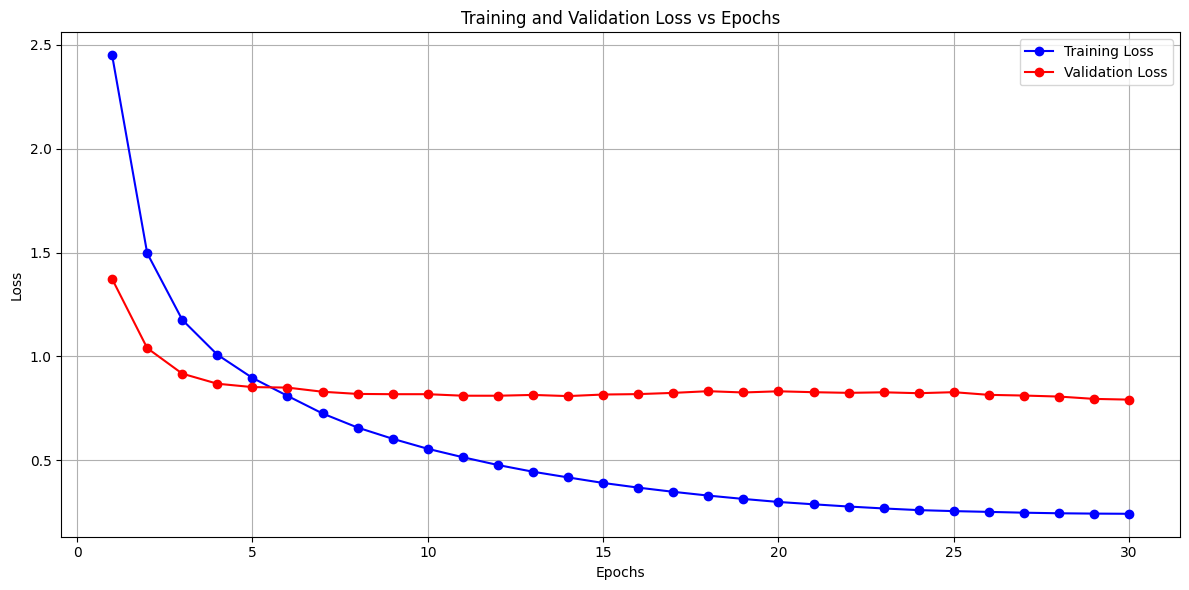

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(train_epochs, train_loss, label="Training Loss", color="blue", marker="o")
plt.plot(val_epochs, val_loss, label="Validation Loss", color="red", marker="o")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plotting Decoder Loss and Retriever Loss for Validation Set vs Epochs

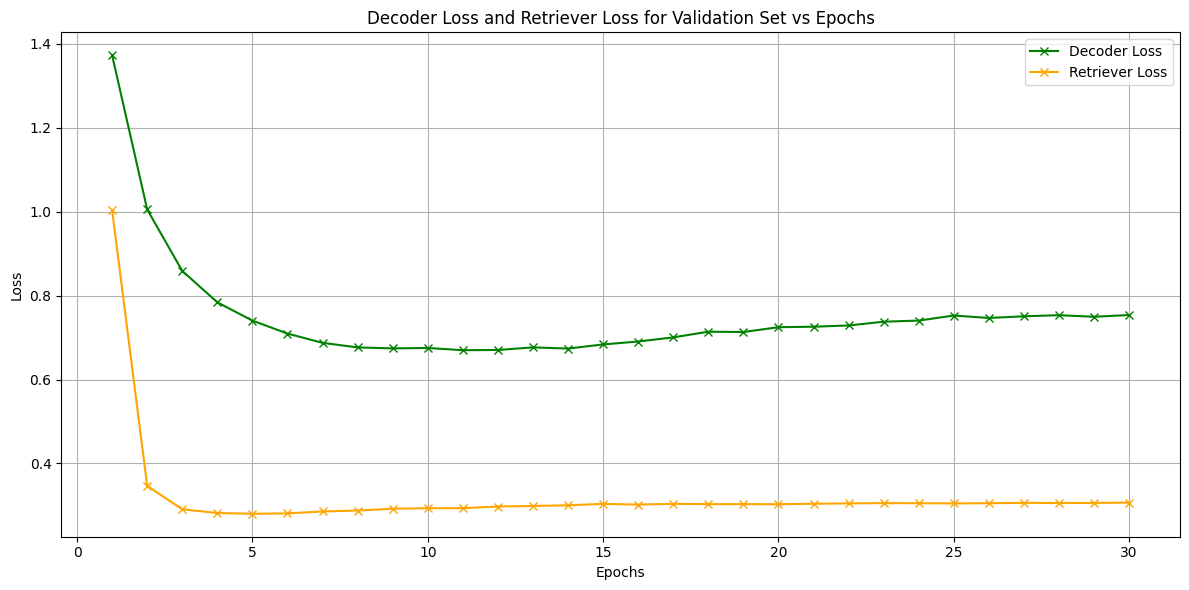

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(val_epochs, decoder_val_loss, label="Decoder Loss", color="green", marker="x")
plt.plot(val_epochs, retriever_val_loss, label="Retriever Loss", color="orange", marker="x")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Decoder Loss and Retriever Loss for Validation Set vs Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plotting the Fusion Parameters (Alpha, Beta, Gamma) vs Epochs

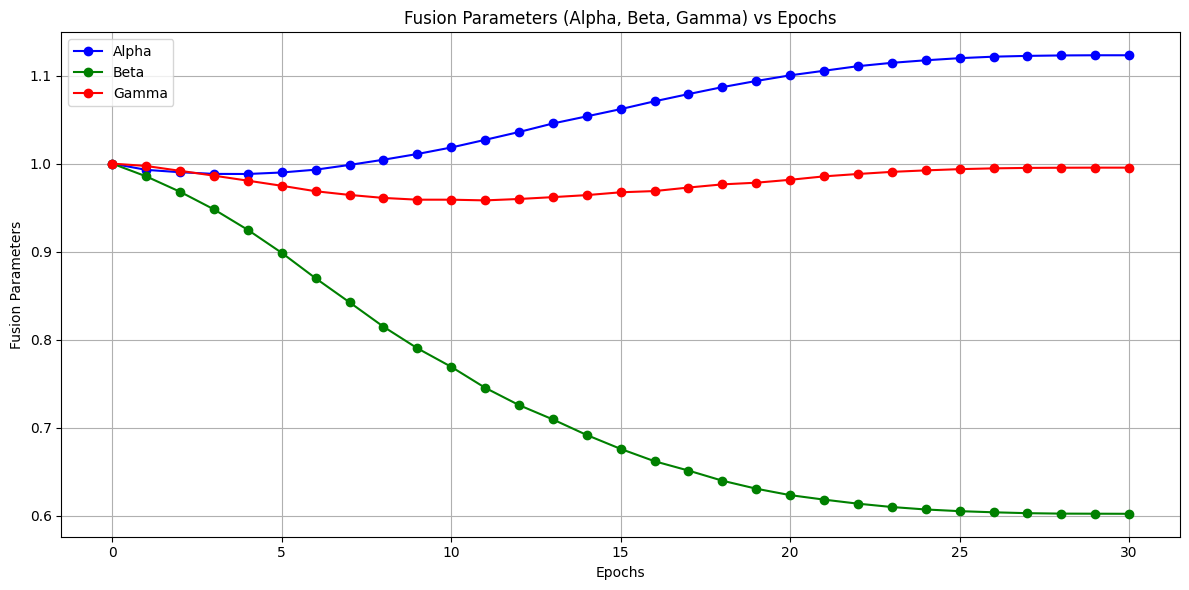

In [23]:
alpha_values = [1] + alpha_values
beta_values = [1] + beta_values
gamma_values = [1] + gamma_values
train_epochs = [0] + train_epochs

plt.figure(figsize=(12, 6))
plt.plot(train_epochs, alpha_values, label="Alpha", color="blue", marker="o")
plt.plot(train_epochs, beta_values, label="Beta", color="green", marker="o")
plt.plot(train_epochs, gamma_values, label="Gamma", color="red", marker="o")
plt.xlabel('Epochs')
plt.ylabel('Fusion Parameters')
plt.title('Fusion Parameters (Alpha, Beta, Gamma) vs Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Inference

In [31]:
import torch
import matplotlib.pyplot as plt
import random
from PIL import Image
from vlmrag.vlmrag_model import VLMRAG
from utils.config import load_config

# Load configuration
cfg = load_config()

# Set device
device = cfg['device']
ckpt_path = cfg['ckpt_path']

# Load the model and its checkpoints
model = VLMRAG(mode='inference')
state_dict = torch.load(ckpt_path, map_location=device)
model.retriever.project.load_state_dict(state_dict['retriever_proj'])
model.decoder.load_state_dict(state_dict['decoder'])

model.to(device)


VLMRAG(
  (retriever): Retriever(
    (project): Sequential(
      (0): Linear(in_features=1536, out_features=1024, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=512, out_features=384, bias=True)
    )
    (embedder): SentenceTransformer(
      (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
      (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
      (2): Normalize()
    )
  )
  (fusion): FusionModule()
  (decoder): Decoder(
    (projection): Sequential(
      (0): Linear(in_features=3072, out_features=1536, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.2, i

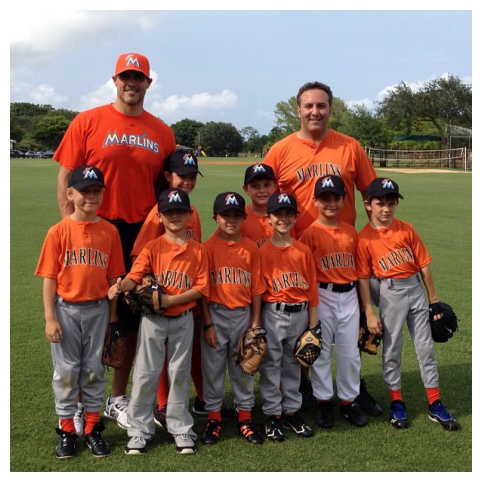

Query: Describe this image.
Description: A baseball player holding a bat near a field as a player takes a swing. Bats are flying mammals of the order Chiroptera (). With their forelimbs adapted as wings, they are the only mammals capable of true and sustained flight.


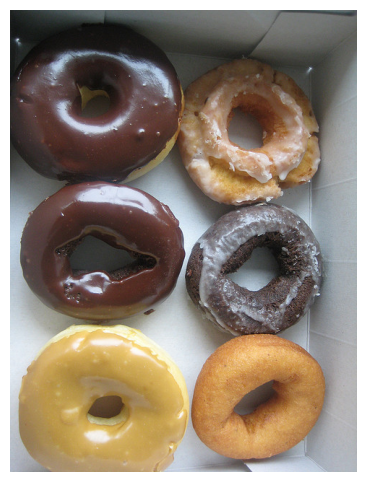

Query: What is happening here?
Description: Doughnut shop in a fair way on wooden spoon In botany, a doughnut or donut () is a type of pastry made from leavened fried dough.: 275 It is popular in many countries and is prepared in various forms as a sweet snack that can be homemade or purchased in bakeries, supermarkets, food stalls, and franchised specialty vendors. Doughnut is the traditional spelling, while donut is the simplified version; the terms are used interchangeably. Doughnuts are usually deep fried from a flour dough, but other types of batter


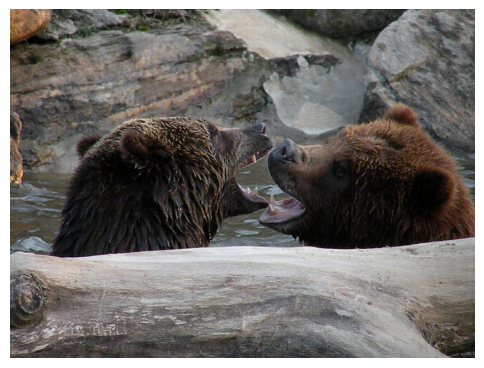

Query: Give me a brief description of this image.
Description: A small bear lying down next to a large rock. Bears are carnivoran mammals of the family Ursidae (). They are classified as caniforms, or doglike carnivorans. Rock most often refers to: Rock (geology), a naturally occurring solid aggregate of minerals or mineraloids Rock music, a genre of popular music Rock or Rocks may also refer to:


In [37]:
with open('train_exp/run_epoch30_lr0.0002_bs16_20250708-135228/test_images.txt', 'r') as f:
    image_paths = f.readlines()

# Select 3 random image paths
random_images = random.sample(image_paths, 3)

queries = [
    "Describe this image.",
    "What is happening here?",
    "Give me a brief description of this image."
]

for idx, image_path in enumerate(random_images):
    image_path = image_path.strip()
    query = queries[idx]

    output = model([image_path], [query])

    img = Image.open(image_path)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    text = f"Query: {query}\nDescription: {output}"
    print(text)
